In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import random
import math
import itertools
import pandas as pd
import pylab
from matplotlib import cm

## a) Grafique los 150 puntos y comente la distribución de los datos

Text(0, 0.5, 'Ancho (cm)')

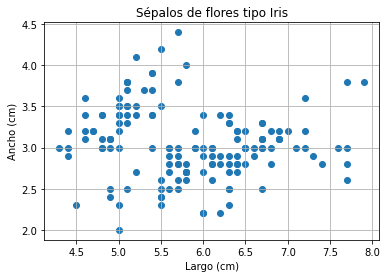

In [2]:
# Se exportan los datos del .txt
filename = 'datosIris.txt'
data = np.loadtxt(filename, delimiter=',', skiprows=0, dtype=str)

# Se crea un arreglo para gaurdar los datos de forma numérica
datos = np.zeros((len(data), 2))

# Se llena el arreglo numérico con los datos numéricos
for i in range(len(data)):
    for j in range(0,2):
        datos[i][j] = float(data[i][j])

# Se grafican todos los datos
plt.scatter(datos[:,0], datos[:,1])
plt.grid()
plt.title('Sépalos de flores tipo Iris')
plt.xlabel('Largo (cm)')
plt.ylabel('Ancho (cm)')

Se puede notar que la mayoría de las observaciones del largo y ancho de los sépalos están distribuidos alrededor de un largo entre los 5.5 cm y los 7cm para un alto entre los 2 cm y y los 3.5 cm. Por otro lado, también se puede notar una pequeña concentración de datos para largos entre los 4 cm y los 6 cm y un ancho entre los 3 cm y los 4.5 cm.

## b) Implemente el algoritmo EM.

Estime la función de densidad que genera estos datos 2-dimensionales como una combinación de **tres** funciones de densidad Gaussianas. Es decir, 

$$ p(x) = \sum_{k=1}^{3} \alpha_k N(x; \mu_k, Q_k)$$ 

Grafique los puntos en el archivo, y traslape el contorno de la función de densidad combinada p(x) (NO el contorno de cada función de densidad base por separado) para varias de las iteraciones del algoritmo. Comente los resultados obtenidos. No puede utilizar funciones preestablecidas de Gaussianas, ni funciones que combinan distribuciones.

In [3]:
def gauss(x, mu, Cx):
    n = np.shape(Cx)[0]
    return (1/(np.sqrt((2*np.pi)**(n)*(np.linalg.det(Cx)))))*np.exp((-1/2)*(np.transpose(x-mu)@np.linalg.inv(Cx))@(x-mu))

# Función para crear una nueva lista de thetas, dependiendo del número de funciones n que se quieran combinar.
def create_thetas(n):
    x = [[] for num in range(n)]
    return x

In [4]:
# Entradas
# maxIt: máximas iteraciones que se permite que el algoritmo haga
# k: cantidad de funciones que se van a combinar para crear la función de densidad compuesta.
# thetak: lista de parámetros thetak, cada elemento de la lista es una lista que contiene una media y una matriz de covarianza.
# alphak: lista de parámetros alphak, cada elemento de la lista es un valor de alpha.
# datos: arreglo de los datos sobre los cuales se quiere encontrar la función de densidad compuesta.

# Salidas
# thetak_final: arreglo de parámetros de las funciones combinadas que forman la función compuesta que mejor se ajusta a los datos.
# p: función compuesta por las diferentes combinaciones de Gaussianas
def EM(maxIt, tol, thetak0, alphak, datos):
    c=0 # Contador para el while
    k = len(thetak0) # Número de funciones Gaussianas que se quieren combinar.
    m = len(datos) # Cantidad de datos
    Y = np.zeros((m,len(thetak0))) # Matriz de gammas: cada columna corresponde a cada gamma_k
    norma = 100
    regu = 0.01*np.eye(2) 

    while(c < maxIt and norma > tol ):
        
        # En este recorrido se llena la matriz de gammas.
        # suma = 0
        # denominadores = []
        # for r in range(len(thetak0)):
        #     suma = 0
        #     for i in range(m):
        #         suma = suma + alphak[r]*gauss(np.array(np.matrix(datos[i])).T, thetak0[r][0], thetak0[r][1] + regu)
        #     denominadores.append(suma)

        # for j in range(len(thetak0)):
        #     for i in range(m):
        #         Y[:,j][i] = alphak[j]*gauss(np.array(np.matrix(datos[i])).T, thetak0[j][0], thetak0[j][1] + regu)/denominadores[j]

        # E-Step
        den = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(np.array(np.matrix(datos[i])).T, thetak0[r][0], thetak0[r][1] + regu)
            den = den + alphak[r]*Nm

        num = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(np.array(np.matrix(datos[i])).T, thetak0[r][0], thetak0[r][1] + regu)
            num = alphak[r]*Nm
            Y[:,r] = np.array(np.matrix(np.divide(num, den))).T

        # M-Step

        # En este recorrido se calcula el Nk
        Nk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:,j][i]
            Nk.append(suma)

        # En este recorrido se calcula el alphak
        alphak = []
        for i in range(len(thetak0)):
            alphak.append(Nk[i]/m)

        # En este recorrido se calculan las nuevas medias (muk).
        muk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:,j][i]*np.array(np.matrix(datos[i])).T
            muk.append(suma/Nk[j])

        # En este recorrido se calculan las nuevas matrices de covarianza (Ck).
        Ck = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                dato = np.array(np.matrix(datos[i])).T
                suma = suma + Y[:,j][i]*(dato-muk[j])@(dato-muk[j]).T
            Ck.append(suma/Nk[j])
    

        # Se crea una nueva lista de thetas, para luego guardar los encontrados en la iteración actual.
        thetak_new = create_thetas(len(thetak0))
        for i in range(len(thetak0)):
            thetak_new[i].append(muk[i])
            thetak_new[i].append(Ck[i])

        norma = np.linalg.norm(thetak_new[0][0] - thetak0[0][0])
        # El valor "nuevo" de thetak ahora será el usado en la siguiente iteración 
        thetak0 = thetak_new
        c+=1

    # # Cuando se llegue al número máximo de iteraciones
    thetak_final = thetak0

    return thetak_final, c

In [5]:
# Condiciones iniciales
mu1 = np.array([[5], [5]])
mu2 = np.array([[2], [3]])
mu3 = np.array([[5.21], [8]])

C1 = np.array([[1, 0], [0, 1]])
C2 = np.array([[1, 0], [0, 1]])
C3 = np.array([[1, 0], [0, 1]])
thetak = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]
theta3 = [mu3, C3]

thetak.append(theta1)
thetak.append(theta2)
thetak.append(theta3)

alphak = []
alpha1 = 1/3
alpha2 = 1/3
alpha3 = 1/3

alphak.append(alpha1)
alphak.append(alpha2)
alphak.append(alpha3)

maxIts = 1000
tol = 10**-4

params, its = EM(maxIts, tol, thetak, alphak, datos)
print(f'its: {its}')

its: 20


primera: [array([[6.23565966],
       [2.86894099]]), array([[0.46961674, 0.12567873],
       [0.12567873, 0.11175816]])]

segunda: [array([[4.97626903],
       [3.39224469]]), array([[0.10261305, 0.06549936],
       [0.06549936, 0.08924565]])]

tercera: [array([[5.54283039],
       [4.1059738 ]]), array([[0.04278317, 0.01703581],
       [0.01703581, 0.05240719]])]


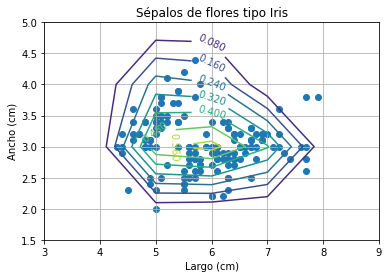

In [10]:
print(f'primera: {params[0]}\n')
print(f'segunda: {params[1]}\n')
print(f'tercera: {params[2]}')

XPoints = []
YPoints = []

rango = range(-10, 10, 1)

for val in rango:
    XPoints.append(val)
    YPoints.append(val)

# Z values as a matrix
ZPoints = np.ndarray((len(rango),len(rango)))

# Necesario solo para hacer la gráfica en 3D
X, Y = np.meshgrid(XPoints,YPoints)

regu = 0.01*np.eye(2)

# Calculamos el valor correspondiente a cada par de coordenadas x, y
for x in XPoints:
    for y in YPoints:
        v = np.array([[YPoints[y]],[XPoints[x]]])
        # v = np.array([[XPoints[x]],[YPoints[y]]])
        # v = np.array([[y],[x]])
        f = gauss(v, params[0][0], params[0][1] + regu) + gauss(v, params[1][0], params[1][1] + regu) + gauss(v, params[2][0], params[2][1] + regu)
        ZPoints[x][y] = f

# Set the x axis and y axis limits
pylab.xlim([3,9])
pylab.ylim([1.5,5])
contours = plt.contour(XPoints, YPoints, ZPoints)
plt.clabel(contours, inline=1, fontsize=10)
plt.grid()
plt.scatter(datos[:,0], datos[:,1])
plt.title('Sépalos de flores tipo Iris')
plt.xlabel('Largo (cm)')
plt.ylabel('Ancho (cm)')

plt.show()

def plotter(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.plot_surface(X, Y, ZPoints, cmap=cm.coolwarm)
    ax.view_init(elev=E, azim=A)
    plt.show()

# from ipywidgets import interactive
# iplot = interactive(plotter,
#                     E = (-90,90, 5),
#                     A = (-90,90,5)
#                     )
# iplot

## c) Repita el procedicimiento del punto b) para una combinación de **cuatro** Gaussiandas.

In [7]:
# Condiciones iniciales
mu1 = np.array([[5], [5]])
mu2 = np.array([[2], [3]])
mu3 = np.array([[5.21], [8]])
mu4 = np.array([[1], [8]])

C1 = np.array([[1, 0], [0, 1]])
C2 = np.array([[1, 0], [0, 1]])
C3 = np.array([[1, 0], [0, 1]])
C4 = np.array([[1, 0], [0, 1]])

thetak2 = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]
theta3 = [mu3, C3]
theta4 = [mu4, C4]

thetak2.append(theta1)
thetak2.append(theta2)
thetak2.append(theta3)
thetak2.append(theta4)

alphak2 = []
alpha1 = 1/4
alpha2 = 1/4
alpha3 = 1/4
alpha4 = 1/4

alphak2.append(alpha1)
alphak2.append(alpha2)
alphak2.append(alpha3)
alphak2.append(alpha4)

maxIts2 = 500
tol2 = 10**-4

params2, its2 = EM(maxIts2, tol2, thetak2, alphak2, datos)
print(f'its: {its2}')

its: 20


primera: [array([[6.23565896],
       [2.86894051]]), array([[0.46961777, 0.12567942],
       [0.12567942, 0.11175828]])]

segunda: [array([[4.9762001 ],
       [3.39216237]]), array([[0.10259362, 0.06547393],
       [0.06547393, 0.08920995]])]

tercera: [array([[5.54287695],
       [4.10599474]]), array([[0.04277565, 0.0170429 ],
       [0.0170429 , 0.05242171]])]

cuarta: [array([[5.45465516],
       [3.99337787]]), array([[0.05567634, 0.02416708],
       [0.02416708, 0.0623825 ]])]


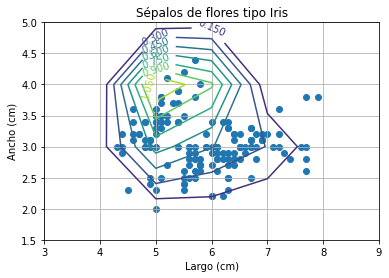

In [8]:
print(f'primera: {params2[0]}\n')
print(f'segunda: {params2[1]}\n')
print(f'tercera: {params2[2]}\n')
print(f'cuarta: {params2[3]}')

XPoints = []
YPoints = []

rango = range(-10, 10, 1)

for val in rango:
    XPoints.append(val)
    YPoints.append(val)

# Z values as a matrix
ZPoints = np.ndarray((len(rango),len(rango)))

# Necesario solo para hacer la gráfica en 3D
X, Y = np.meshgrid(XPoints,YPoints)

regu = 0.1*np.eye(2)

# Calculamos el valor correspondiente a cada par de coordenadas x, y
for x in XPoints:
    for y in YPoints:
        v = np.array([[YPoints[y]],[XPoints[x]]])
        # v = np.array([[XPoints[x]],[YPoints[y]]])
        # v = np.array([[y],[x]])
        f = gauss(v, params2[0][0], params2[0][1] + regu) + gauss(v, params2[1][0], params[1][1] + regu) + gauss(v, params2[2][0], params2[2][1] + regu) + gauss(v,          params2[3][0], params2[3][1] + regu)
        ZPoints[x][y] = f

# Set the x axis and y axis limits
pylab.xlim([3,9])
pylab.ylim([1.5,5])
contours = plt.contour(XPoints, YPoints, ZPoints)
plt.clabel(contours, inline=1, fontsize=10)
plt.grid()
plt.scatter(datos[:,0], datos[:,1])
plt.title('Sépalos de flores tipo Iris')
plt.xlabel('Largo (cm)')
plt.ylabel('Ancho (cm)')

plt.show()

def plotter(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.plot_surface(X, Y, ZPoints, cmap=cm.coolwarm)
    ax.view_init(elev=E, azim=A)
    plt.show()

# from ipywidgets import interactive
# iplot = interactive(plotter,
#                     E = (-90,90, 5),
#                     A = (-90,90,5)
#                     )
# iplot

In [9]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
print(var.pdf([1,0]))

x = np.array([[1],[0]])
mean = np.array([[0],[0]])
cov = np.array([[1,0],[0,1]])

var2 = gauss(x, mean, cov)
print(float(var2))

0.09653235263005393
0.09653235263005391
